In [1]:
%load_ext autoreload
%autoreload 2

In [ ]:
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.colors import ListedColormap

from pathlib import Path
from tqdm.auto import tqdm

from PIL import Image

import torch
device = "cuda" if torch.cuda.is_available() else "cpu"

from TokEye.extra.eval.silbidopy.eval import Metrics

In [3]:
blue_cmap = ListedColormap(['none', 'blue'])
red_cmap = ListedColormap(['none', 'red'])

In [61]:
metrics = Metrics(device="cpu")

In [4]:
model = torch.load(
    "/scratch/gpfs/nc1514/TokEye/model/big_mode_v1.pt",
    weights_only=False,
    map_location=device,
    )
model.eval()
print("Model loaded")

Model loaded


In [56]:
threshold = 0.5

In [49]:
data_path = Path("/scratch/gpfs/nc1514/TokEye/data/eval/TJII2021")

In [50]:
shotns = [name.stem.split("_")[1] for name in data_path.glob("input/*.png")]

In [51]:
mean, std = 0, 0
for shotn in tqdm(shotns):
    input_path = data_path / "input" / f"spectrogram_{shotn}.png"
    input_img = Image.open(input_path).convert('L')
    input_img = np.array(input_img)
    mean += input_img.mean()
    std += input_img.std()
mean /= len(shotns)
std /= len(shotns)
mean, std

  0%|          | 0/493 [00:00<?, ?it/s]

(np.float64(17.84620821169868), np.float64(25.016818830630463))

In [78]:
shotn = shotns[90]

In [79]:
input_path = data_path / "input" / f"spectrogram_{shotn}.png"
gt_path = data_path / "gt" / f"spectrogram_{shotn}.png"

In [80]:
# Load images
spec = Image.open(input_path).convert('L')  # Convert to grayscale
ann = Image.open(gt_path).convert('L')

spec, ann = np.array(spec), np.array(ann)
spec, ann = np.flip(spec, axis=0), np.flip(ann, axis=0)
spec, ann = spec.copy(), ann.copy()

spec = (spec - mean) / std
ann = ann // 255.0

ann_tensor = torch.from_numpy(ann)
ann_tensor = ann_tensor.unsqueeze(0).unsqueeze(0).float()

input_tensor = torch.from_numpy(spec).float()
input_tensor = input_tensor.unsqueeze(0).unsqueeze(0)

with torch.no_grad():
    spec_tensor = input_tensor.to(device)
    out_tensor = model(spec_tensor)[0]

out_tensor = out_tensor[:,0:1]
out_tensor = torch.sigmoid(out_tensor)
out_tensor = out_tensor.cpu()

scores = metrics(out_tensor > threshold, ann_tensor)

out = out_tensor.squeeze(0).squeeze(0).numpy()

In [81]:
for key, value in scores.items():
    print(f"{key}: {value}")

generalized_dice_score: 0.10354923456907272
hausdorff_distance: 121.3342514038086
iou: 0.05460159108042717
precision: 0.456429123878479
recall: 0.9504032135009766


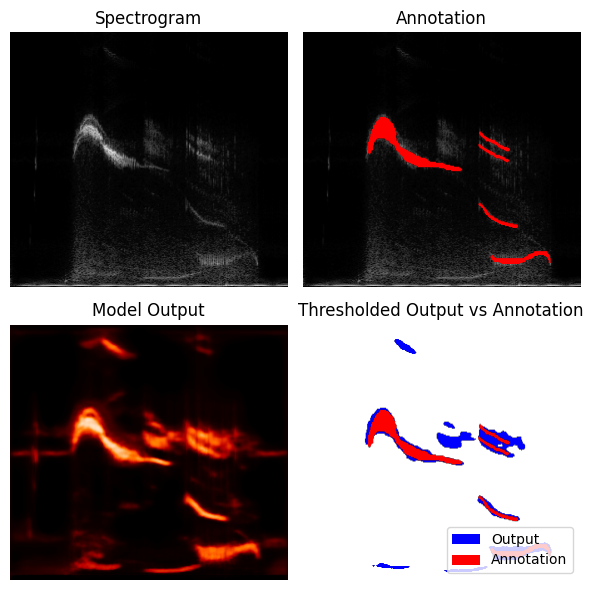

In [82]:
fig, axes = plt.subplots(2, 2, figsize=(6, 6))

axes[0, 0].imshow(spec, aspect="auto", cmap="gray", origin="lower")
axes[0, 0].set_title("Spectrogram")
axes[0, 0].axis("off")

axes[0, 1].imshow(spec, aspect="auto", cmap="gray", origin="lower")
axes[0, 1].imshow(ann, aspect="auto", cmap=red_cmap, alpha=ann.astype(float), origin="lower")
axes[0, 1].set_title("Annotation")
axes[0, 1].axis("off")

axes[1, 0].imshow(out, aspect="auto", cmap="gist_heat", vmin=0, vmax=1, origin="lower")
axes[1, 0].set_title("Model Output")
axes[1, 0].axis("off")

axes[1, 1].imshow(out > threshold, aspect="auto", cmap=blue_cmap, label="Model", origin="lower")
axes[1, 1].imshow(ann, aspect="auto", cmap=red_cmap, label="Annotation", zorder=2, origin="lower")
axes[1, 1].set_title("Thresholded Output vs Annotation")
legend_elements = [
    Patch(facecolor='blue', label='Output'),
    Patch(facecolor='red', label='Annotation')
]
axes[1, 1].legend(handles=legend_elements, loc="lower right")
axes[1, 1].axis("off")

plt.tight_layout()
plt.show()